# Calculating the effective conductivity of a proppant fluid mixture

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from SimPEG import Maps
from matplotlib import rcParams
from string import ascii_lowercase
%matplotlib inline

In [55]:
rcParams['font.size'] = 12

In [3]:
sigma_fluid = 3
sigma_proppant_default = 1e4

## Wenner Conductivity Bounds

In [4]:
def getCondBounds(sig0, sig1, phi1):
    phi0   = 1.0-phi1
    sigWup = phi0*sig0 + phi1*sig1
    sigWlo = 1.0/(phi0/sig0 + phi1/sig1)
    W = np.array([sigWlo, sigWup])

    return W

## 2 phase EMT, spherical inclusions
- conductive proppant + fluid

In [60]:
sigma1 = np.logspace(1, 5, 5) # look at a range of proppant conductivities
phi = np.linspace(0.0, 1, 2000) # vary the volume of proppant

In [61]:
scemt = Maps.SelfConsistentEffectiveMedium(sigma0=sigma_fluid, sigma1=1, nP=len(phi), maxIter=100)

In [62]:
sige = np.zeros([phi.size, sigma1.size])

for i, s in enumerate(sigma1):
    scemt.sigma1 = s
    sige[:, i] = scemt * phi

/Users/lindseyjh/git/python_symlinks/SimPEG/Maps.py:891: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


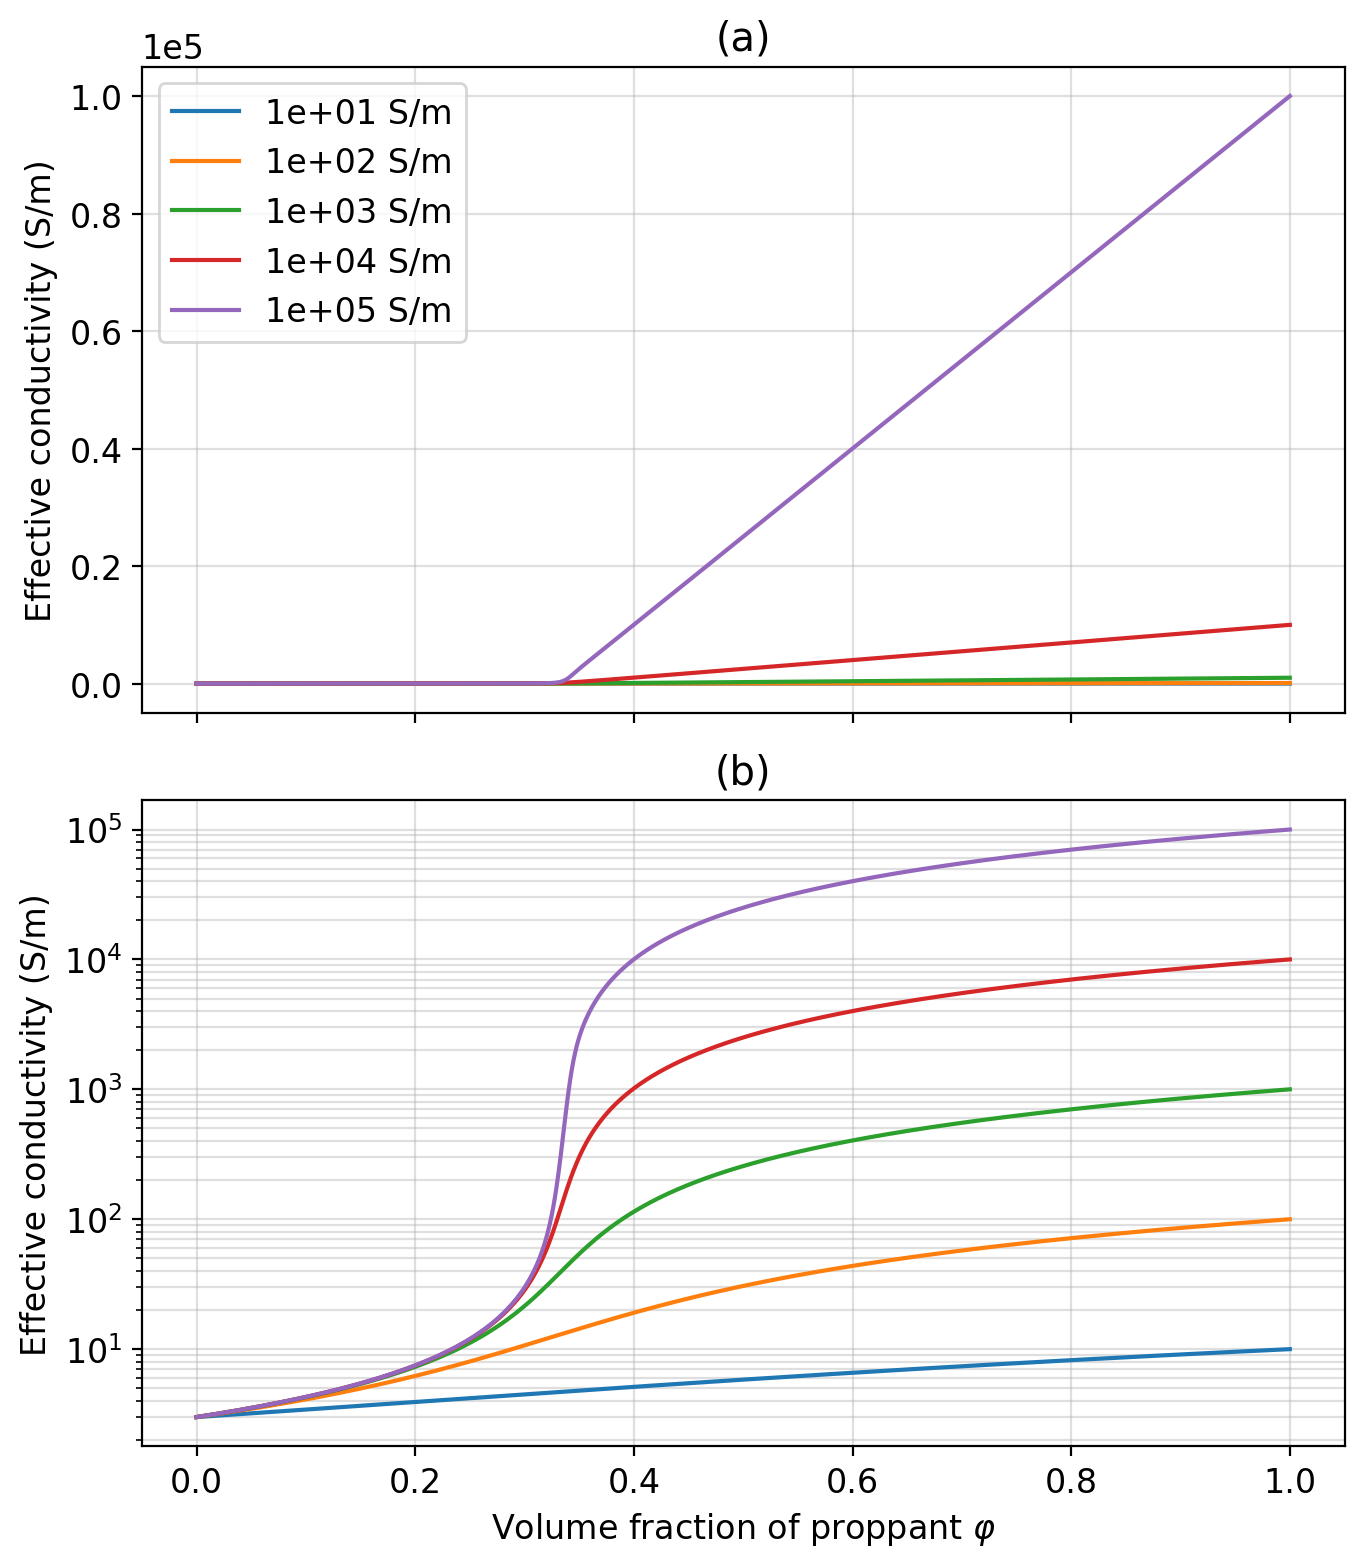

In [63]:
fig, ax = plt.subplots(2, 1, figsize=(7, 8), dpi=200)

ax[1].semilogy(phi, sige)
ax[0].plot(phi, sige)
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 

for i, a in enumerate(ax):
    a.grid(which="both", alpha=0.4)
    a.set_xlabel("Volume fraction of proppant $\\varphi$")
    a.set_ylabel("Effective conductivity (S/m)")
    a.set_title("({})".format(ascii_lowercase[i]))
    
    if i == 0:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        a.legend(["{:1.0e} S/m".format(s) for s in sigma1])
plt.tight_layout()

fig.savefig("../figures/emt_spherical_particles", dpi=200, bbox_inches="tight")

## Vary the conductivity of the fluid

In [45]:
scemt = Maps.SelfConsistentEffectiveMedium(sigma0=sigma_fluid, sigma1=sigma_proppant_default)

In [46]:
sigma0 = np.r_[0.3, 3, 30, 300]
sigma1 = np.r_[1e3, 1e4]
phi = np.linspace(0.0, 1, 1000) # vary the volume of proppant

In [47]:
sige = np.zeros([phi.size, sigma0.size, sigma1.size])

for j, sp in enumerate(sigma1):
    scemt.sigma1 = sp
    for i, s in enumerate(sigma0):
        scemt.sigma0 = s
        sige[:, i, j] = scemt * phi

/Users/lindseyjh/git/python_symlinks/SimPEG/Maps.py:891: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


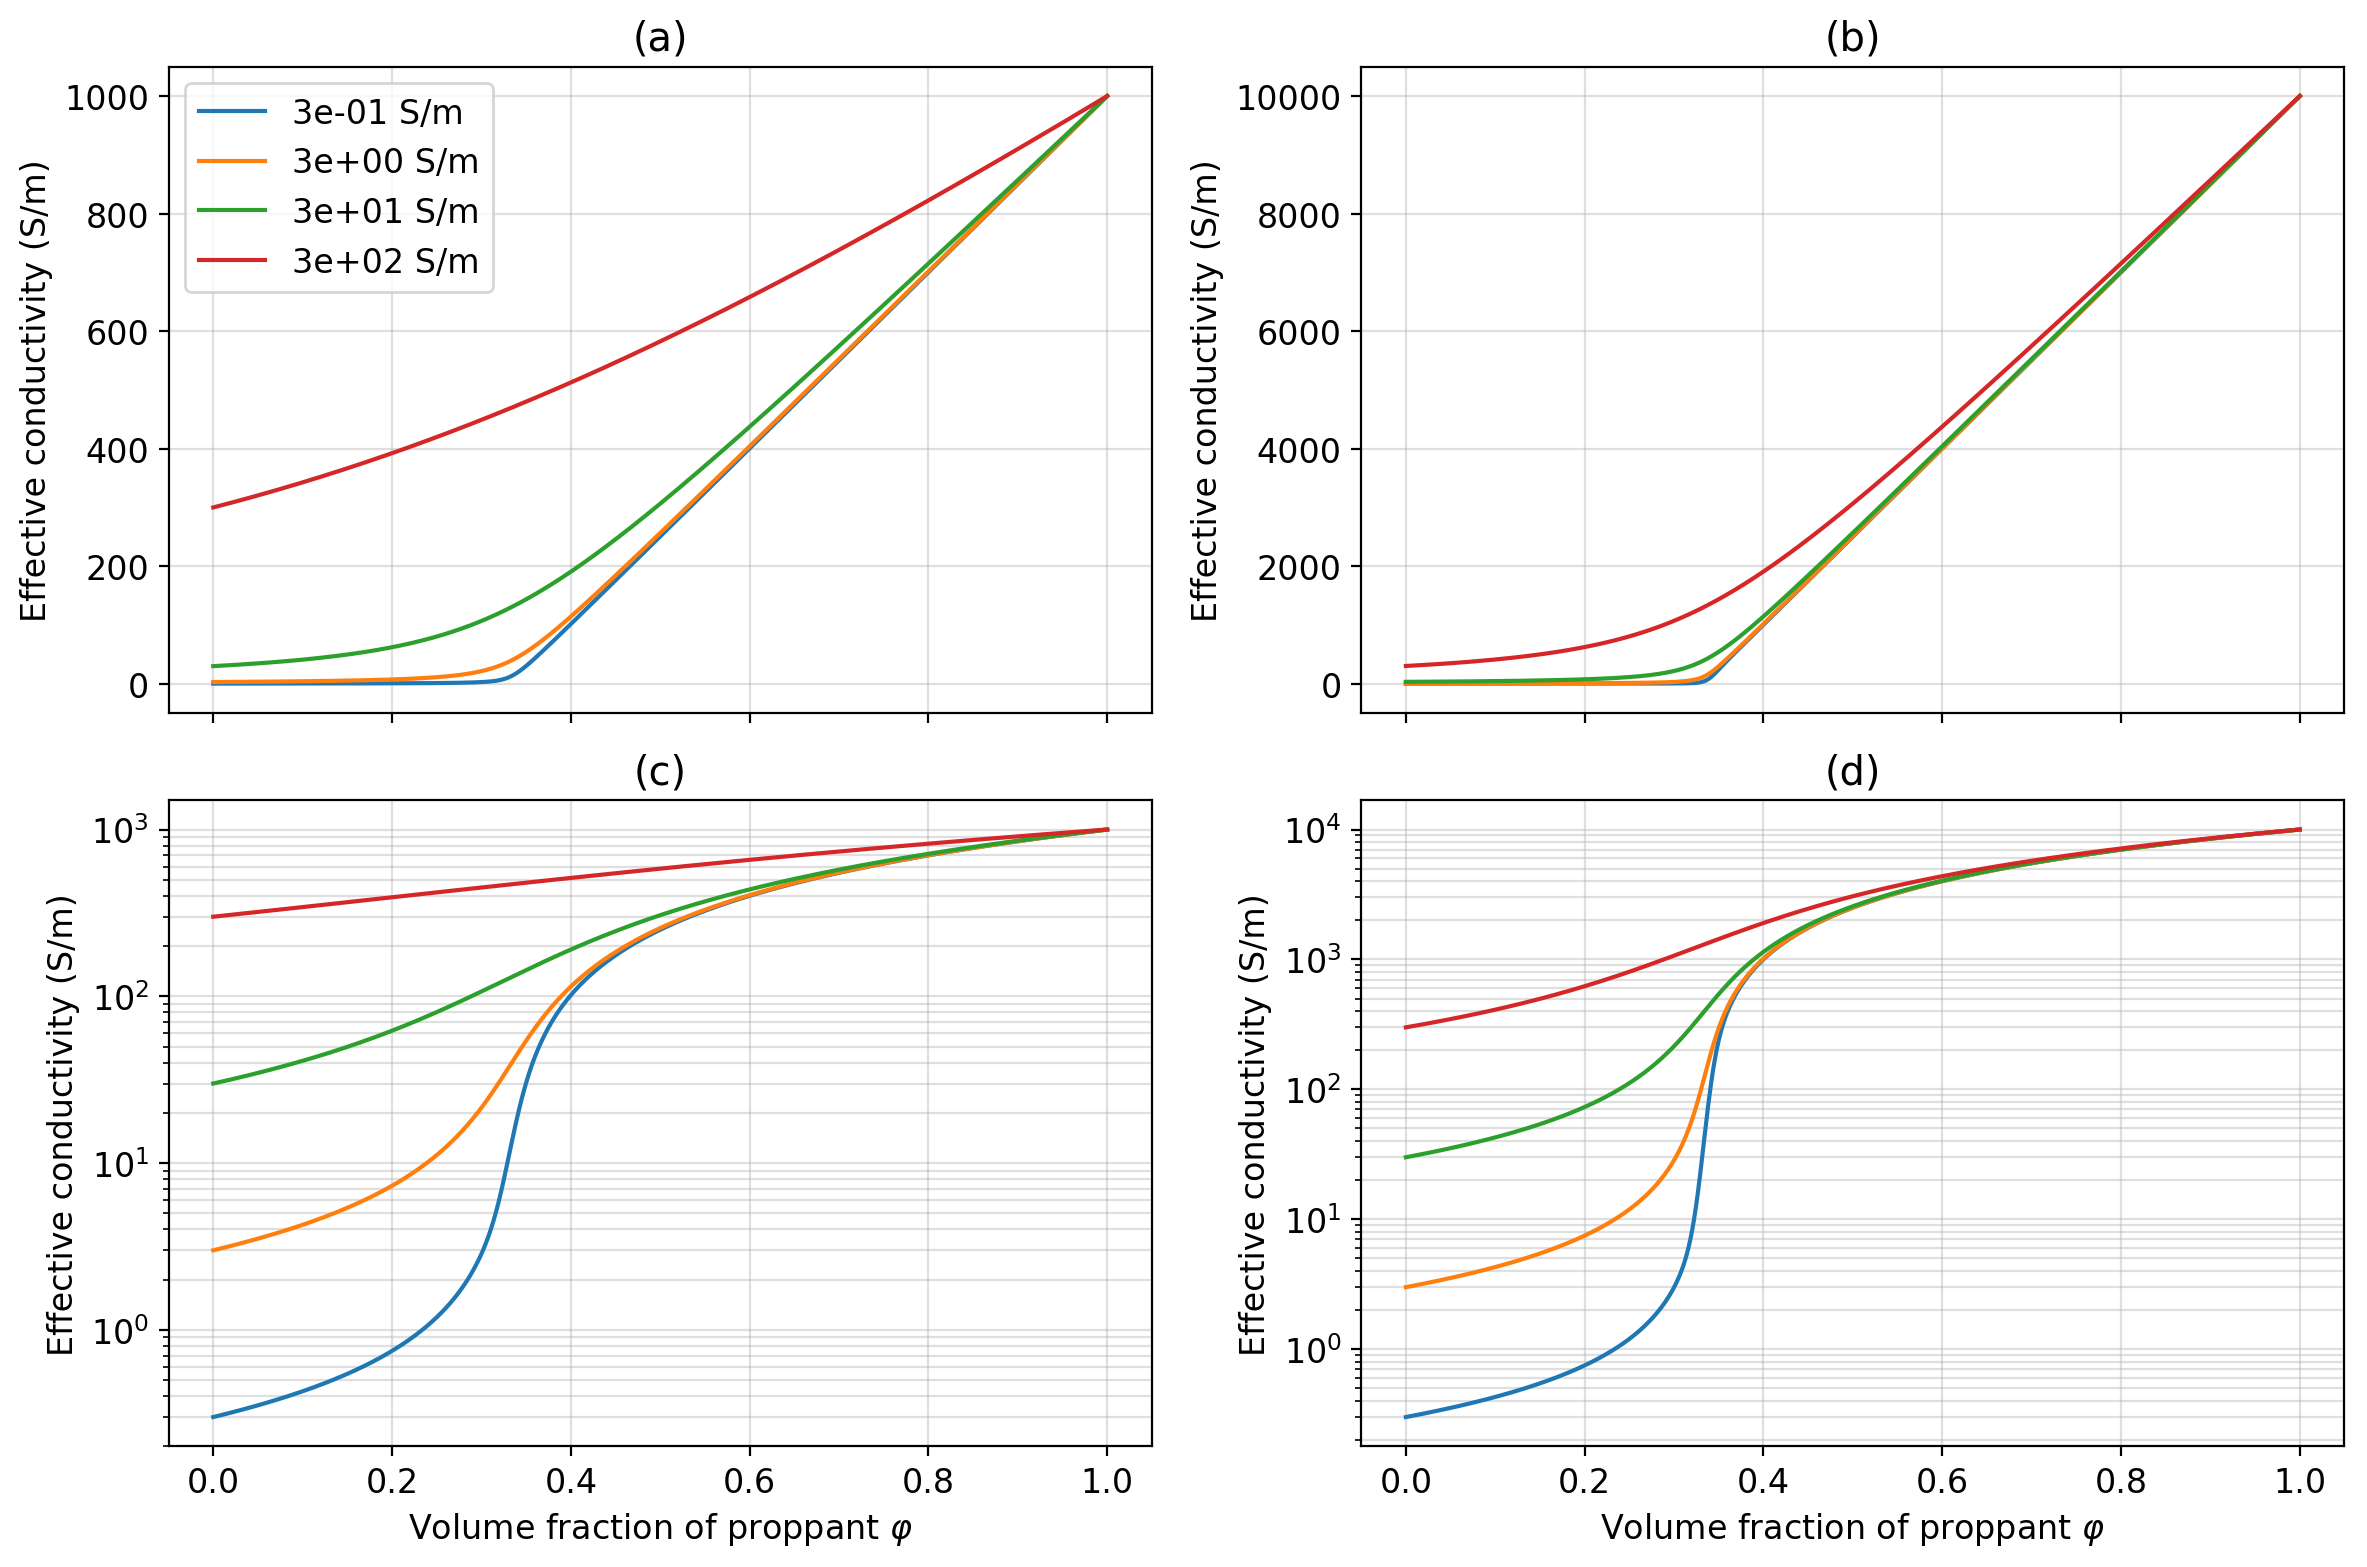

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), dpi=200)


for j in range(len(sigma1)):

    ax[0, j].plot(phi, sige[:, :, j])
    ax[0, j].grid(which="both", alpha=0.4)
    ax[0, j].set_ylabel("Effective conductivity (S/m)")
    ax[0, j].set_xlabel("Volume fraction of proppant $\\varphi$")
    
    ax[1, j].semilogy(phi, sige[:, :, j])
    ax[1, j].grid(which="both", alpha=0.4)
#     ax[1, j].legend(["{:1.0e} S/m".format(s) for s in sigma0])
    ax[1, j].set_xlabel("Volume fraction of proppant $\\varphi$")
    ax[1, j].set_ylabel("Effective conductivity (S/m)")
    
for a in ax[0, :]:
    a.set_xlabel('')
    a.set_xticklabels(['']*len(a.get_xticklabels()))
#     a.legend(["{:1.0e} S/m".format(s) for s in sigma1])

    

ax[0, 0].legend(["{:1.0e} S/m".format(s) for s in sigma0])
[a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate(ax.flatten())]

plt.tight_layout()

fig.savefig("../figures/emt_fluid", dpi=200, bbox_inches="tight")

## 3 phase EMT
- conventional, resistive proppant with conductive, spherical proppant in conductive fluid

In [65]:
def multiphase_emt(phi, sigmas, alphas=None):
#     sigstart = scemt.wennerBounds(phi[0])[0]
    sige1 = np.min(sigmas)
    
    if alphas is None:
        alphas = np.ones(len(sigmas))

    for i in range(100):
        R = [scemt.getR(s, sige1, alp) for s, alp in zip(sigmas, alphas)]

        den = np.sum([p*r for p, r in zip(phi, R)], 0)  # phi0*R0 + phi1*R1
        num = np.sum([p*s*r for p, s, r in zip(phi, sigmas, R)], 0)  # phi0*scemt.sigma0*R0 + phi1*scemt.sigma1*R1

        sige2 = num/den
        relerr = np.abs(sige2-sige1)

        if np.all(relerr <= scemt.tol):
#             if scemt.sigstart is None:
#                 scemt.sigstart = sige2  # store as a starting point for the next time around
            return sige2

        sige1 = sige2
    # TODO: make this a proper warning, and output relevant info (sigma0, sigma1, phi, sigstart, and relerr)

    return sige2

In [66]:
sig_3phase = [sigma_fluid, 1e-6, sigma_proppant_default]
phi_cond_prop = [0, 0.25, 0.50, 0.75, 1.]
sige2 = np.zeros([phi.size, len(phi_cond_prop)])

for i, p in enumerate(phi_cond_prop):
    phi_pf = [1-phi, (1-p)*phi, p*phi]
    assert np.allclose(np.sum(phi_pf, 0), 1), "{}".format(np.sum(phi_pf, 0))
    sige2[:, i] = multiphase_emt(phi_pf, sig_3phase)

    

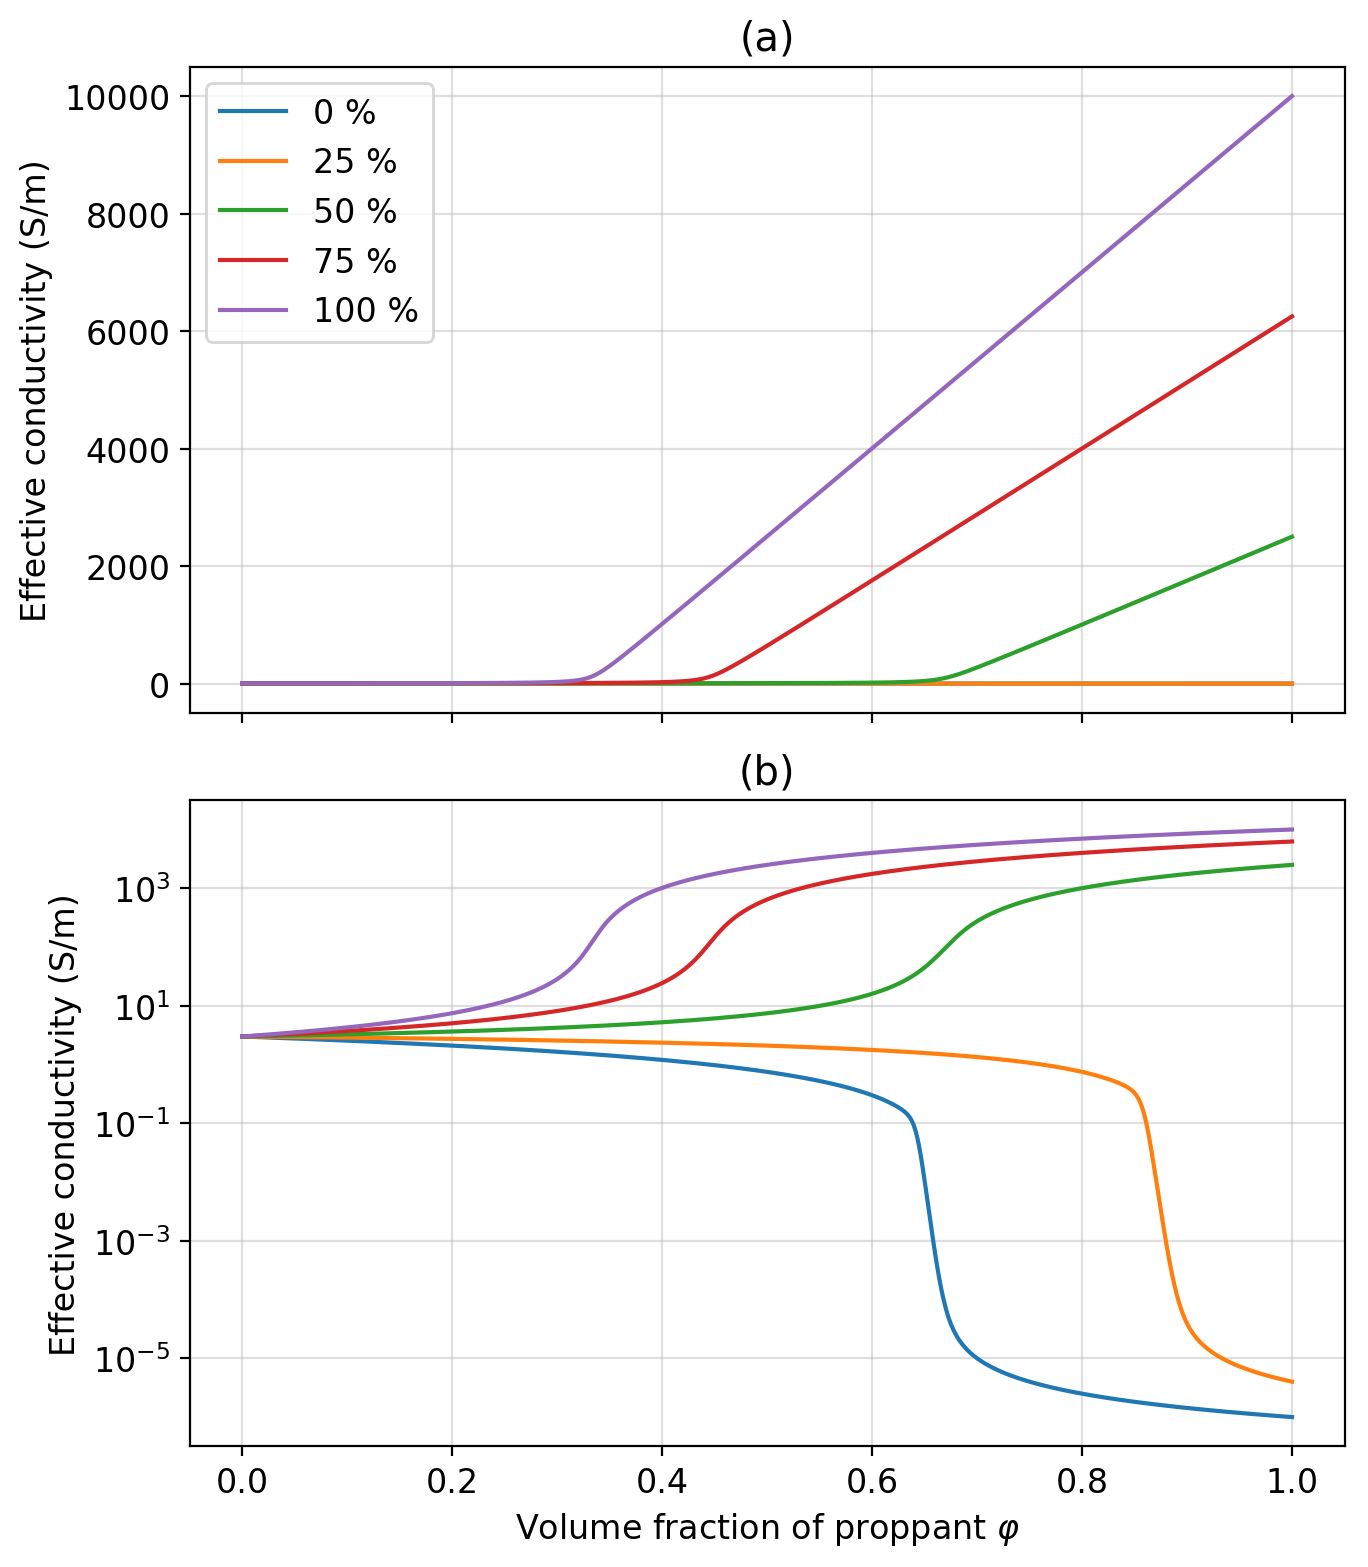

In [74]:
fig, ax = plt.subplots(2, 1, figsize=(7, 8), dpi=200)

ax[0].plot(phi, sige2)
ax[1].semilogy(phi, sige2)

for i, a in enumerate(ax):
    a.grid(which="both", alpha=0.4)
    a.set_xlabel("Volume fraction of proppant $\\varphi$")
    a.set_ylabel("Effective conductivity (S/m)")
    a.set_title("({})".format(ascii_lowercase[i]))
    
    if i == 0:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
#         a.legend(["{:1.0e} S/m".format(s) for s in sigma1])

ax[0].legend(["{:1.0f} %".format(p*100) for p in phi_cond_prop])
plt.tight_layout()

fig.savefig("../figures/emt_3phase", dpi=200, bbox_inches="tight")

## 3 phase with elongated particles
- conventional, resistive proppant with electrically conductive, elongated particles and conductive fluid 

In [72]:
sig_3phase = [3, 1e-6, 1e5]
p = 0.25
phi_pf = [1-phi, (1-p)*phi, p*phi]
aspect = [1, 2, 5, 10, 20, 50]
sige3 = np.zeros([phi.size, len(aspect)])

for i, a in enumerate(aspect):
    sige3[:, i] = multiphase_emt(phi_pf, sig_3phase, np.r_[1, 1, a])


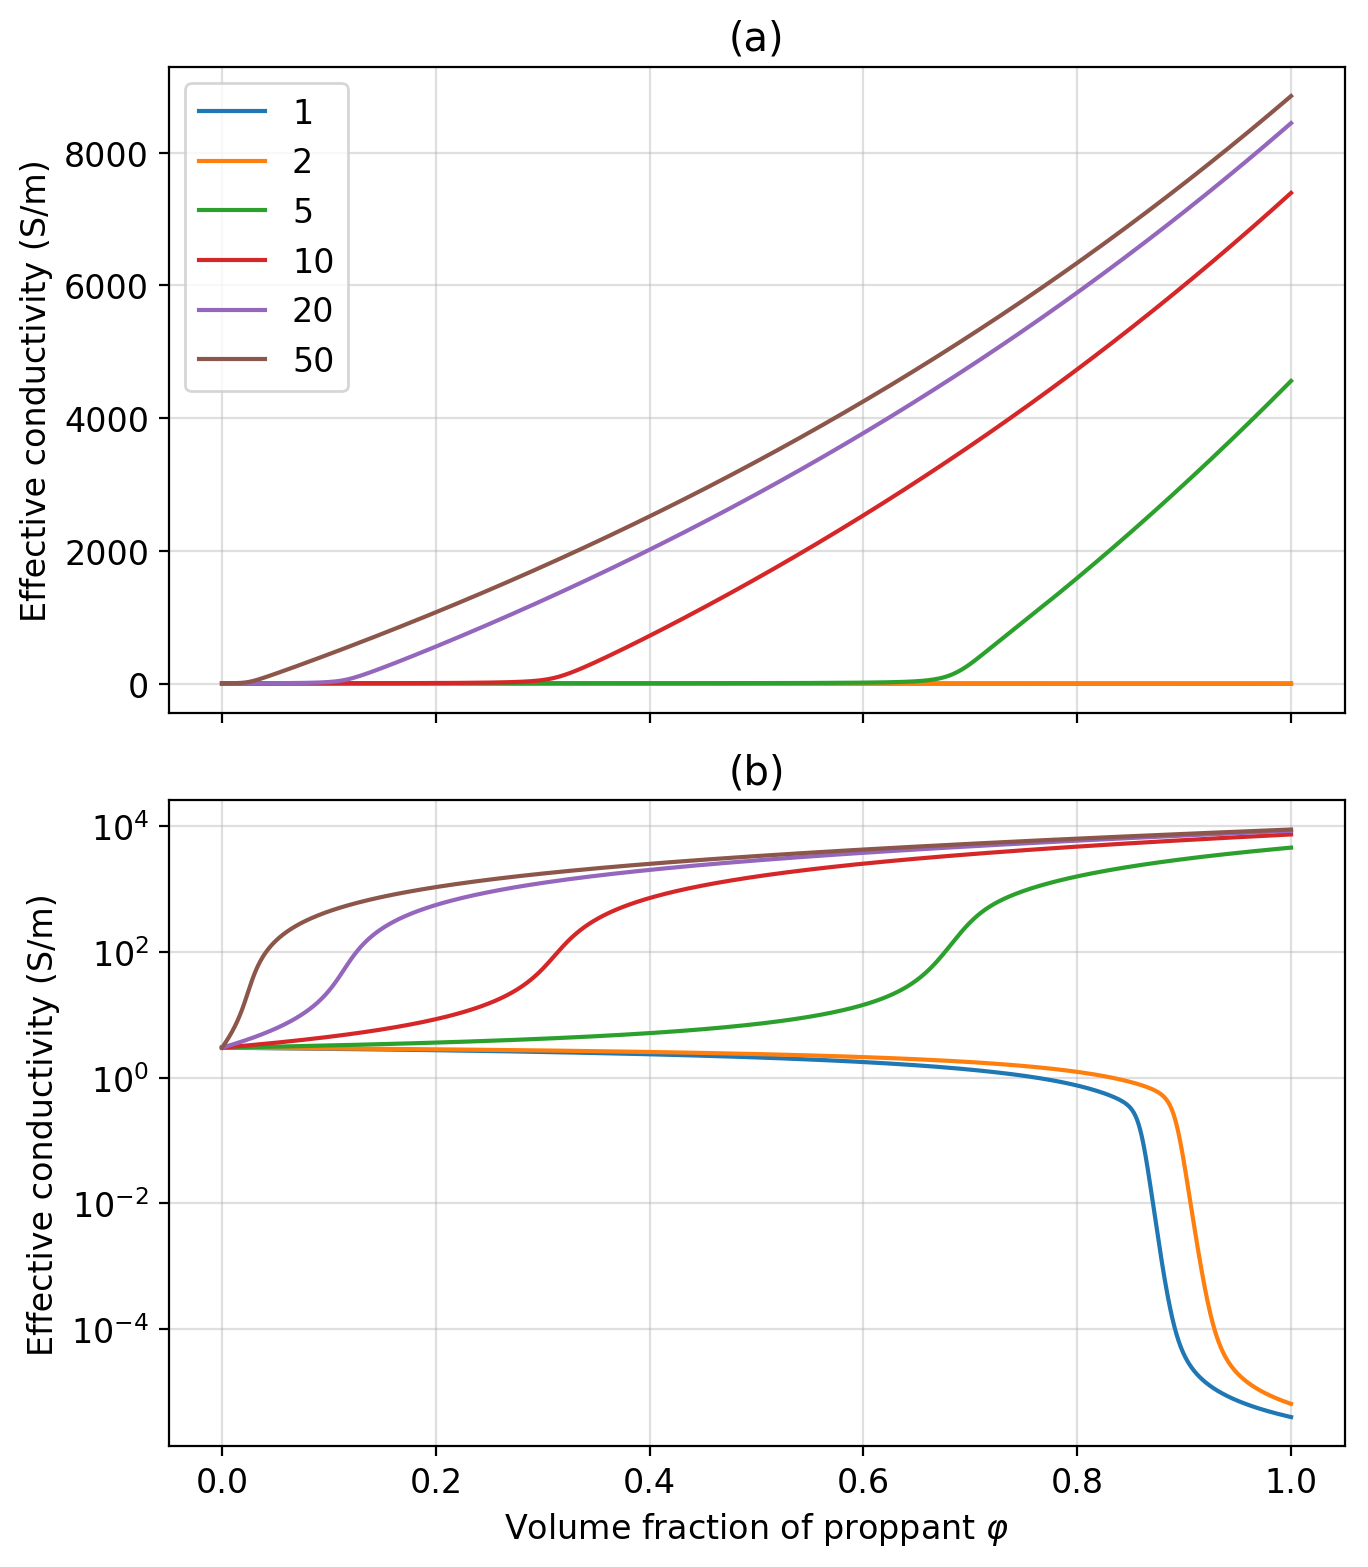

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(7, 8), dpi=200)

ax[0].plot(phi, sige3)
ax[1].semilogy(phi, sige3)

for i, a in enumerate(ax):
    a.grid(which="both", alpha=0.4)
    a.set_xlabel("Volume fraction of proppant $\\varphi$")
    a.set_ylabel("Effective conductivity (S/m)")
    a.set_title("({})".format(ascii_lowercase[i]))
    
    if i == 0:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))

ax[0].legend(["{:1.0f}".format(a) for a in aspect])
plt.tight_layout()

fig.savefig("../figures/emt_3phase_aspect", dpi=200, bbox_inches="tight")